In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from torch_unet.tools.dataset import TrainingSet, TestSet
from torch_unet.unet import UNet
import numpy as np

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split
import torch
import logging
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
from torch_unet.tools.evaluation import eval_net
from torchsummary import summary
from torch_unet.tools.losses import DiceCoeff

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
DATADIR = "../Datasets/training/"
IMAGE_DIR = DATADIR + "images/"
MASK_DIR = DATADIR + "groundtruth/"
MASK_THRESHOLD = 0.25


In [5]:
dataset = TrainingSet(IMAGE_DIR, MASK_DIR, MASK_THRESHOLD, patch_size=80, step=20, rotation_angles=None)

INFO: Created dataset from 100 original images, scale factor 289.0, patch size 80, step 20, rotations None, total images 28900.0


In [3]:
net = UNet(n_channels=3, n_classes=1, depth=4, init_filters=16, padding=True)

In [8]:
from torch_unet.pre_processing import patch
patch.get_image_patches(dataset.get_raw_image(0), patch_size=80, step=40).shape

(81, 80, 80, 3)

In [12]:
from torchviz import make_dot

In [13]:
output = net(torch.zeros((1, 3, 80, 80))).shape

In [23]:
torch.max(torch.rand(1,3,80,80))

tensor(1.0000)

In [16]:
make_dot(output, params=dict(net.named_parameters()))

AttributeError: 'int' object has no attribute 'grad_fn'

In [4]:
summary(net, (3, 80, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 80, 80]             448
              ReLU-2           [-1, 16, 80, 80]               0
            Conv2d-3           [-1, 16, 80, 80]           2,320
              ReLU-4           [-1, 16, 80, 80]               0
        DoubleConv-5           [-1, 16, 80, 80]               0
         MaxPool2d-6           [-1, 16, 40, 40]               0
              Down-7  [[-1, 16, 40, 40], [-1, 16, 80, 80]]               0
            Conv2d-8           [-1, 32, 40, 40]           4,640
              ReLU-9           [-1, 32, 40, 40]               0
           Conv2d-10           [-1, 32, 40, 40]           9,248
             ReLU-11           [-1, 32, 40, 40]               0
       DoubleConv-12           [-1, 32, 40, 40]               0
        MaxPool2d-13           [-1, 32, 20, 20]               0
             Down-14  [[-1, 

In [5]:
img = dataset.get_raw_image(0)

In [49]:
import cv2
sobel=cv2.Sobel(img,cv2.CV_64F,1,1,ksize=5)
edges = cv2.Canny(img, 100 ,200)

error: OpenCV(4.1.2) /io/opencv/modules/imgproc/src/canny.cpp:829: error: (-215:Assertion failed) _src.depth() == CV_8U in function 'Canny'


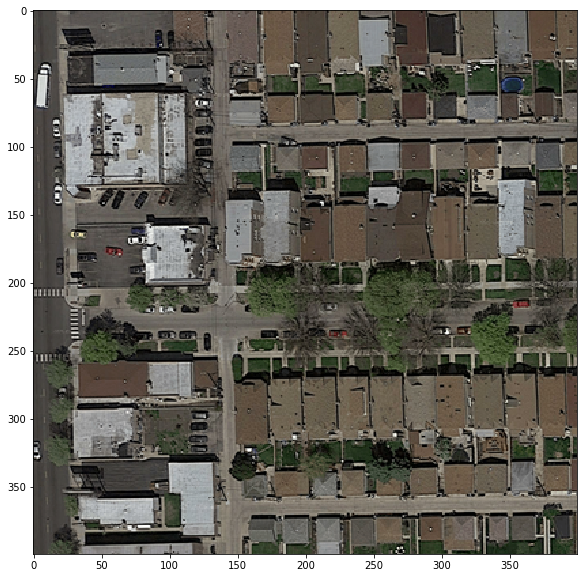

In [44]:
fig, ax = plt.subplots(figsize=(10,10))

plt.imshow(img)

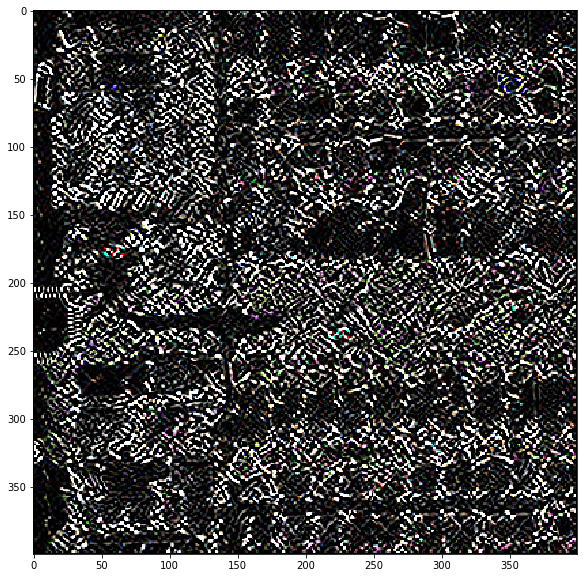

In [48]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(sobel)

In [56]:
from torch_unet.utils import show_side_by_side

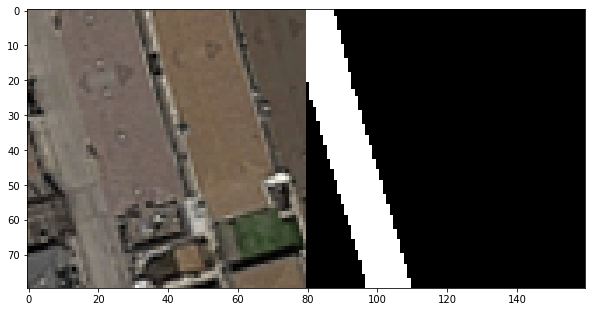

In [74]:
i = 293
img = dataset[i]['image'].detach().numpy().transpose((1,2,0))
mask = dataset[i]['mask'].detach().numpy()[0]
show_side_by_side(img, mask)

In [75]:
289 * 2 * 100

57800

In [2]:
# Register device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')
net = UNet(n_channels=3, n_classes=1, depth=4, padding=True, init_filters=16, dropout=True)
net.to(device=device);

INFO: Using device cpu


In [11]:
torch.load("../../../../../best_model.pt", map_location=device)

ModuleNotFoundError: No module named 'models'

In [9]:
import pickle


In [10]:
pickle.load("../../../../../best_model.pt")

TypeError: file must have 'read' and 'readline' attributes

In [42]:
net.load_state_dict(state_dict=torch.load("../models/depth4_BS128_lr0.001_PS80_ST20_padding_batchnorm_deca, dily_dropout0.2/checkpoints/CP_epoch23.pth", map_location=device))

<All keys matched successfully>

In [101]:
import cv2
def post_process_prediction(img):
    img_post = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel=np.ones((25, 25), np.uint8))
    #img_post = cv2.morphologyEx(img_post, cv2.MORPH_OPEN, kernel=np.ones((8, 8), np.uint8))
    #dilated = cv2.dilate(img_post, kernel=np.ones((2, 2), np.uint8), iterations=1)
    
    return img_post

In [102]:
i = 2
img = mpimg.imread(f"../Datasets/test_set_images/test_{i}.png")
mask = predict_full_image(net, img, device)
mask = (mask > 0.25) * 1

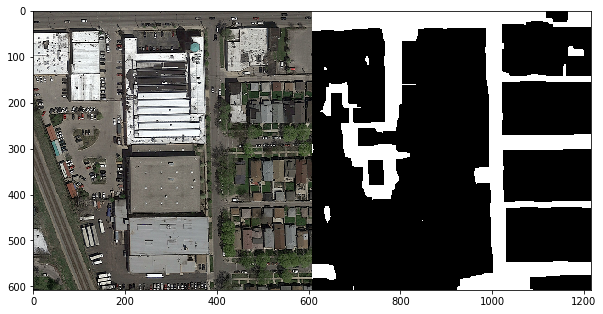

In [103]:
show_side_by_side(img, post_process_prediction(np.uint8(mask)))

In [52]:
import pandas as pd
import matplotlib.image as mpimg

In [53]:
import re
def patch_to_label(patch):
    df = np.mean(patch)
    if df > 0.5:
        return 1
    else:
        return 0


def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    #im = ((im > 0.5) * 1)
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i: i + patch_size, j: j + patch_size]
            label = patch_to_label(patch)
            yield ("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, "w") as f:
        f.write("id,prediction\n")
        for fn in image_filenames[0:]:
            f.writelines("{}\n".format(s) for s in mask_to_submission_strings(fn))

In [152]:
submission_filename = "../Datasets/submission.csv"
image_filenames = []
for i in range(1, 51):
    image_filename = "../predictions/test_" + "%.d" % i + ".png"
    image_filenames.append(image_filename)

masks_to_submission(submission_filename, *image_filenames)

In [62]:
#submission = pd.read_csv("../../../../../road_segmentation/submissions/submission_17-12-2019.csv")
#submission = pd.read_csv("../Datasets/submission.csv")
submission = pd.read_csv("../submission.csv")
solution = pd.read_csv("../Datasets/solution.csv").rename(columns={'prediction': 'actual'}).drop(columns=['Usage'])
merged = submission.merge(solution, on='id')

In [63]:
solution.shape[0], merged.shape[0]

(72200, 72200)

In [64]:
tp = merged[(merged['actual'] == 1) & (merged['prediction'] == 1)]['id'].count()
fn = merged[(merged['actual'] == 1) & (merged['prediction'] == 0)]['id'].count()
fp = merged[(merged['actual'] == 0) & (merged['prediction'] == 1)]['id'].count()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

In [65]:
f1_score, precision, recall

(0.8798698701367964, 0.91371289322109, 0.8484443301619954)

In [88]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

In [102]:
sigmoid = nn.Sigmoid()

t = np.round(np.random.rand(64))[:, None]
o = np.random.rand(64,1) - 0.5

t = Variable(torch.Tensor(t))
o = Variable(torch.Tensor(o))



In [104]:
print(nn.BCEWithLogitsLoss()(sigmoid(o), t))
print(nn.BCELoss()(sigmoid(o), t)) # Different numbers

tensor(0.7197)
tensor(0.6861)


In [99]:
t.shape

torch.Size([64, 1])

In [92]:
o.shape

torch.Size([64, 1])